# Tarea 1: Activaciones y pasada hacia adelante en una red neuronal <br/> CC6204 Deep Learning, Universidad de Chile 


In [3]:
# Este notebook está pensado para correr en CoLaboratory. 
# Lo único imprescindible por importar es torch 
import torch

# Parte 1: Funciones de activación y función de salida

En esta parte se programarán varias funciones que serán de utilidad cuando construyas tu red neuronal.


## 1a) Funciones de activación

En esta parte se programarán las siguientes funciones de activación:

*   `relu`, que para cada valor $x$ en un tensor computa el máximo entre $0$ y $x$,  
*   `swish`, propuesta en el artículo [Searching for Activation Functions](https://arxiv.org/abs/1710.05941), y
*   `celu`, propuesta en el artículo [Continuously Differentiable Exponential Linear Units](https://arxiv.org/abs/1704.07483).

En cada caso se recibe un tensor (de cualquier cantidad de dimensiones) y se entrega un tensor con la función aplicada a todos sus elementos. La aplicación de las funciones se hace *punto a punto*, por lo que el tensor de salida de cada función tiene las mismas dimensiones que el tensor de entrada.

In [4]:
def sig(T):
  return torch.reciprocal(1 + torch.exp(-1 * T))

def tanh(T):
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

In [5]:
def sig(T):
  return torch.reciprocal(1 + torch.exp(-1 * T))

def tanh(T):
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

def relu(T):
  return torch.clamp(T, min=0)
  
def swish(T, beta):
  return sig(T*beta)*T

def celu(T,alpha):
  M1 = torch.clamp(T, min=0)
  M2 = torch.clamp(T, max=0)

  M3 = (torch.exp(M2/alpha) - 1) * alpha

  return M3 + M1




## 1b) Softmax

En esta parte se programa la función `softmax`. Esta es una función tal que para una secuencia de valores $(x_1,\ldots,x_n)$  el resultado de $\text{softmax}(x_1,\ldots,x_n)$ es otra secuencia $(s_1,\ldots,s_n)$ que cumple con
\begin{equation}
s_i = \frac{e^{x_i}}{\sum_{j=1}^{n}e^{x_j}}
\end{equation}
Para esto, primero se demuestra que si a cada elemento de $(x_1,\ldots,x_n)$ se le resta el mismo valor, entonces el resultado de `softmax` no varía. Es decir que $\text{softmax}(x_1-M,\ldots,x_n-M)=\text{softmax}(x_1,\ldots,x_n)$. Esto se usa para programar una versión de `softmax` que primero le resta a todos los elementos el máximo valor de la secuencia. Esta nueva versión debiera ser numéricamente más estable.

La función recibe un tensor y el resultado de `softmax` debiera calcularse sobre alguna dimensión del tensor dejando todas las demás dimensiones fijas. Para esto la función recibe el parámetro `dim` (que indica la dimensión). El resultado de `softmax` es siempre un tensor de las mismas dimensiones de la entrada.

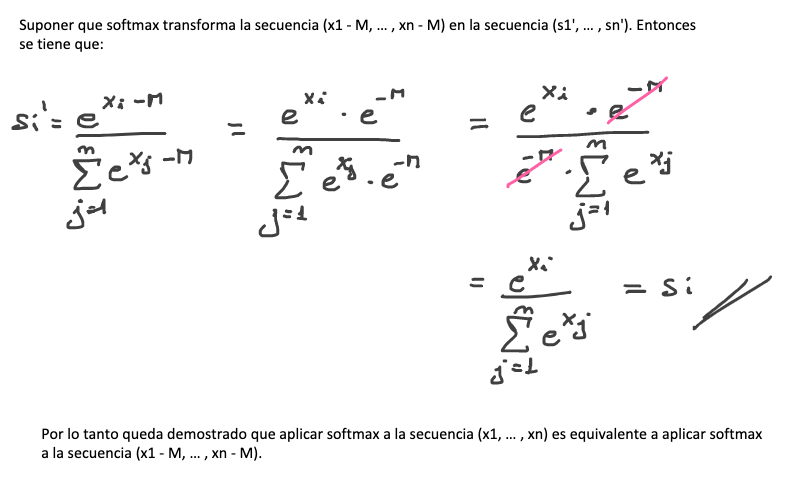

In [6]:
def softmax(T, dim, estable=True):
  
  if estable == True:
    M=torch.max(T)
    T=T-M
    
  ex=torch.exp(T)
  sumatoria= torch.sum(ex,dim,keepdim=True)
  return torch.div(ex,sumatoria)

# Parte 2: Red neuronal y pasada hacia adelante (forward)

En esta parte se programará la red neuronal, en particular la pasada hacia adelante para una red que resolverá problemas de clasificación con varias clases. Supondremos que cada capa se verá de la forma
\begin{equation}
h^{(\ell)} = f^{(\ell)}(h^{(\ell-1)} W^{(\ell)}+b^{(\ell)})
\end{equation}
y que la predicción final estará dada por
\begin{equation}
\hat{y} = \text{softmax}(h^{(L)}U+c).
\end{equation}

## 2a) Clase para red neuronal

La clase `FFNN` recibe en su inicializador los siguientes parámetros:

*   Cantidad de neuronas de la capa de entrada `F`
*   Lista de cantidades de neuronas en cada capa escondida `l_h`
*   Lista de funciones de activación `l_a`
*   Cantidad de neuronas de la capa de salida `C` (`C` $\geq 2$)

Una llamada de ejemplo para crear un objeto de la clase es:
```python
red_neuronal = FFNN(300,[50,30],[relu,sig],10)
``` 
lo que debiera crear todos los parámetros para una red con 300 neuronas en la capa de entrada, luego una capa escondida de 50 neuronas con activación relu, luego una capa con 30 neuronas y activación sigmoid y finalmente una capa de 10 neuronas de salida. <br><br>

In [7]:
class FFNN(torch.nn.Module):
  def __init__(self, F, l_h, l_a, C,cte=[]):
    super(FFNN, self).__init__()
    weightsList = []
    biasList = []
    activationList = l_a

    weightsList.append(torch.nn.Parameter(torch.randn(F,l_h[0])))
    for i in range(len(l_h)-1):
      weightsList.append(torch.nn.Parameter(torch.randn(l_h[i],l_h[i+1])))
      biasList.append(torch.nn.Parameter(torch.zeros(1,l_h[i])))
    weightsList.append(torch.nn.Parameter(torch.randn(l_h[-1],C)))
    biasList.append(torch.nn.Parameter(torch.zeros(1,C)))

    self.biasList = torch.nn.ParameterList(biasList)
    self.weightsList = torch.nn.ParameterList(weightsList)
    self.activationList = l_a
    self.cte=cte

  def trained_weights(self, *wList):
    weightsList=[]
    for w in wList:
      weightsList.append(torch.nn.Parameter(w))

    self.weightsList = torch.nn.ParameterList(weightsList)

  def trained_bias(self,*bList):
    biasList=[]
    for b in bList:
      biasList.append(torch.nn.Parameter(b))
    self.biasList = torch.nn.ParameterList(biasList)

  def predict(self, output):
    return torch.argmax(output,dim=1)
  
  #Iterador para mostrar/imprimir un resumen de los parámetros de la red
  def resumen(self):
    for name, param in self.named_parameters():
      print(name)
      print(param)
      print(param.size())

  #Computa la pasada hacia adelante
  #La función recibe un tensor de dimensiones (B,F) como entrada donde 
  #B es el tamaño del mini paquete de ejemplos pasados a la red, y F la cantidad 
  #de features de cada ejemplo
  # El resultado es un tensor de dimensiones (B,C) 
  #donde C representa la cantidad de clases a clasificar.
  def forward(self, x):

    result=x
    
    for i in range(len(self.weightsList)): ##for i in range(l_h+1)
      result=torch.mm(result,self.weightsList[i]) + self.biasList[i]
      cte_index=0
      if i != len(self.weightsList)-1:
        if self.activationList[i] == celu or self.activationList[i] == swish:
          result=self.activationList[i](result, self.cte[cte_index])
          cte_index +=1
        else:
          result=self.activationList[i](result)

      else:
        return softmax(result, dim=1)

# Parte 3: Probando tu red con parámetros pre-entrenados para MNIST

En esta parte se usará la pasada hacia adelante de la red con parámetros de una red pre-entrenada. La red fue entrenada con el conjunto de datos MNIST que contiene datos de dígitos escritos a mano. La versión original de los datos junto con una descripción del conjunto y resultados para distintos métodos de clasificación, se pueden encontrar en http://yann.lecun.com/exdb/mnist/

## 3a) Cargando y visualizando datos de MNIST

Se descargan y procesan los datos de MNIST.

In [8]:
# Importamos MNIST desde torchvision.
from torchvision.datasets import MNIST

# Importamos una función para convertir imágenes en tensores.
from torchvision.transforms import ToTensor

# Importamos funcionalidades útiles para mirar los datos.
from matplotlib.pyplot import subplots
import random 
from random import randint

# Descarga y almacena el conjunto de prueba de MNIST.
dataset = MNIST('mnist', download= True,train=False, transform=ToTensor())
print('Cantidad total de datos:',len(dataset))

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw




Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!
Cantidad total de datos: 10000


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Los datos en todo dataset de pytorch se pueden acceder indexándolos como si fueran un arreglo. En el caso de MNIST cada dato es un par que contiene un tensor `T` y un entero `l`, en donde `T` representa a la imágen de un dígito, y `l` representa el valor numérico de ese dígito. Exploremos el primero de estos datos:

In [9]:
T, l = dataset[0]

print('Tensor')
print('tipo:', T.type())
print('dimensiones:', T.size())
print()
print('Entero')
print('valor:', l)

Tensor
tipo: torch.FloatTensor
dimensiones: torch.Size([1, 28, 28])

Entero
valor: 7


El tensor `T` representa una imagen de 28x28 pixeles. Además la imagen que estamos considerando está en blanco y negro, por lo tanto tiene un solo canal de color. Esto resulta en un tensor de 1x28x28.

## 3b) Cargando los parámetros pre-entrenados

Se usan archivos de texto que representan los parámetros de una red con 2 capas escondidas que fue pre-entrenada para clasificar los datos de MNIST. La red pre-entrenada tiene esta arquitectura

784 --> 32 (relu) --> 16 (relu) --> 10 (softmax)

La cantidad de neuronas en la capa de entrada es 28*28 = 784, esto porque la red espera un vector de características como input.

In [10]:
# Clone the entire repo.
!git clone -l -s https://github.com/dccuchile/CC6204.git cloned-repo
%cd cloned-repo
%cd 2020
%cd tareas
%cd tarea1
%cd mnist_weights

Cloning into 'cloned-repo'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6159 (delta 0), reused 1 (delta 0), pack-reused 6154
Receiving objects: 100% (6159/6159), 7.30 MiB | 24.04 MiB/s, done.
Resolving deltas: 100% (2977/2977), done.
/content/cloned-repo
/content/cloned-repo/2020
/content/cloned-repo/2020/tareas
/content/cloned-repo/2020/tareas/tarea1
/content/cloned-repo/2020/tareas/tarea1/mnist_weights


In [11]:
import numpy as np
from numpy import loadtxt

F=784
l_h=[32,16]
l_a=[relu,relu]
C=10


W1 = torch.from_numpy(loadtxt('W1.txt')).float()
W2 = torch.from_numpy(loadtxt('W2.txt')).float()
b1 = torch.from_numpy(loadtxt('b1.txt')).float()
b2 = torch.from_numpy(loadtxt('b2.txt')).float()
U = torch.from_numpy(loadtxt('U.txt')).float()
c = torch.from_numpy(loadtxt('c.txt')).float()

W1=W1.to('cuda')
W2=W2.to('cuda')
b1=b1.to('cuda')
b2=b2.to('cuda')
U=U.to('cuda')
c=c.to('cuda')

NN=FFNN(F,l_h,l_a,C,2)
NN.trained_weights(W1,W2,U)
NN.trained_bias(b1,b2,c)

## 3c) Calcula la predicción de un ejemplo al azar

Se muestra la predicción que entrega la red para un ejemplo al azar del conjunto de datos y muestra también la imágen y la clase real del ejemplo.

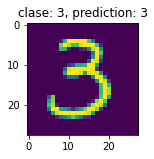

In [12]:
import random
from matplotlib.pyplot import subplots

fig, axs = subplots(nrows=1, figsize=(2,3))
 
idx = random.randint(0,len(dataset))
T, l = dataset[idx]

T=T.view(1,784)
T=T.to('cuda')

prediction=NN.predict(NN.forward(T))
prediction=prediction.to('cpu')
prediction=prediction.numpy()

T=T.to('cpu')
img = T.view(28,28).numpy()
axs.set_title("clase: "+ str(l)+", prediction: " + str(prediction[0]))
axs.imshow(img)

## 3d) Pasando todos los ejemplos por la red con un `DataLoader`

Un `DataLoader` en pytorch es una manera muy útil de entregarle paquetes de ejemplos a una red. Será especialmente útil cuando estemos entrenando. Por ahora lo usaremos sólo para computar la predicción de la red pre-entrenada y calcular el porcentaje de acierto.

Para crear un `DataLoader` solo se debe especificar el conjunto de datos que se usará en la forma de un objeto `DataSet`, y el tamaño del paquete de cada paquete que usaremos. En el siguiente código estamos creando un `DataLoader` desde nuestro objeto `dataset` con paquetes de tamaño 100.

```python
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=100)
```

Una vez creado podemos iterar por todo el dataset haciendo simplemente:

```python
for x, y in dataloader:
  # lo que necesitemos hacer con los datos
```

En cada iteración `x` será un tensor con 100 ejemplos, por lo tanto tendrá dimensiones 100 x 1 x 28 x 28, e `y` será un tensor con las clases correspondientes a cada uno de esos ejemplos, por lo tanto tendrá dimensión 100 (es un tensor con 100 valores enteros).

Se programa una función que usa un `DataLoader` para pasar todos los ejemplos por la red en paquetes y calcular el porcentaje total de acierto que la red obtiene en la predicción. La función recibe a la red con los parámetros cargados, el dataset que se usará, el tamaño del batch para pasar por la red y si el trabajo debe hacerse en la GPU o en la CPU.

In [13]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=100)

# Acá tu código
def calcula_acierto(red, dataset, batch_size=100, device='cuda'):
  success=0
  samples=0
  dataloader = DataLoader(dataset, batch_size=100)
  red.to(device)
  for x, y in dataloader:
    y=y.to(device)
    x=x.view(100,784)
    x=x.to(device)
    output=red.forward(x)
    prediction=torch.argmax(output,dim=1)
    success+=torch.eq(prediction,y).sum()
    samples+=torch.numel(y)

  success=success.to('cpu')
  success=success.numpy()

  print(samples)

  success_percentage= success/samples
  return success_percentage
    

calcula_acierto(NN,dataset)


10000


0.9612